# 📊 Bitcoin Analytics Dashboard
This dashboard-style notebook provides:
- KPI metrics
- Interactive charts
- Technical indicators
- Prophet forecasting

Use the widgets to explore Bitcoin price behavior.

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import ipywidgets as widgets
from ipywidgets import interact
from prophet import Prophet

pd.set_option('display.max_columns', None)


## 📥 Load & Prepare BTC Data

In [4]:

file_path = "Bitcoin_01_01_2024-31_12_2024_historical_data_coinmarketcap.csv"
df = pd.read_csv(file_path, sep=";")

# Convert datetime
df['timeOpen'] = pd.to_datetime(df['timeOpen'])
df = df.sort_values('timeOpen').reset_index(drop=True)

# Clean numeric columns
num_cols = ['open','high','low','close','volume','marketCap','circulatingSupply']
for col in num_cols:
    df[col] = df[col].astype(str).str.replace(',','').astype(float)

df.head()


,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,circulatingSupply,timestamp
0,2023-11-28 00:00:00+00:00,2023-11-28T23:59:59.999Z,2023-11-28T19:43:00.000Z,2023-11-28T05:39:00.000Z,2781,37247.991175,38368.479955,36891.089362,37831.086868,2.169614e+10,7.398131e+11,19555693.0,2023-11-28T23:59:59.999Z
1,2023-11-29 00:00:00+00:00,2023-11-29T23:59:59.999Z,2023-11-29T08:58:00.000Z,2023-11-29T15:14:00.000Z,2781,37826.105522,38366.112997,37612.631623,37858.494055,2.072855e+10,7.403799e+11,19556506.0,2023-11-29T23:59:59.999Z
2,2023-11-30 00:00:00+00:00,2023-11-30T23:59:59.999Z,2023-11-30T04:16:00.000Z,2023-11-30T15:50:00.000Z,2781,37861.118883,38141.753547,37531.141629,37712.747772,1.811598e+10,7.375609e+11,19557337.0,2023-11-30T23:59:59.999Z
3,2023-12-01 00:00:00+00:00,2023-12-01T23:59:59.999Z,2023-12-01T16:35:00.000Z,2023-12-01T00:28:00.000Z,2781,37718.009626,38954.110427,37629.358912,38688.748361,2.351278e+10,7.566900e+11,19558400.0,2023-12-01T23:59:59.999Z
4,2023-12-02 00:00:00+00:00,2023-12-02T23:59:59.999Z,2023-12-02T21:54:00.000Z,2023-12-02T00:32:00.000Z,2781,38689.278617,39678.937287,38652.595676,39476.333280,1.553404e+10,7.721252e+11,19559193.0,2023-12-02T23:59:59.999Z


## 🧮 KPI Dashboard

In [5]:

latest = df.iloc[-1]

price = latest['close']
daily_return = df['close'].pct_change().iloc[-1] * 100
ytd_return = (df['close'].iloc[-1]/df['close'].iloc[0] - 1) * 100
vol_30 = df['close'].pct_change().rolling(30).std().iloc[-1] * np.sqrt(365) * 100

print(f"""
📌 **Key Metrics**
----------------------
💰 Latest Price: {price:,.2f} USD
📈 Daily Return: {daily_return:.2f}%
📅 YTD Return: {ytd_return:.2f}%
📊 30-Day Volatility: {vol_30:.2f}%
""")



📌 **Key Metrics**
----------------------
💰 Latest Price: 93,429.20 USD
📈 Daily Return: 0.85%
📅 YTD Return: 146.96%
📊 30-Day Volatility: 45.33%



## 📈 Interactive Price Chart

In [6]:

@interact(days=widgets.IntSlider(min=30, max=len(df), step=10, value=180))
def plot_price(days):
    subset = df.tail(days)
    plt.figure(figsize=(12,5))
    plt.plot(subset['timeOpen'], subset['close'])
    plt.title(f'BTC Price - Last {days} Days')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()


interactive(children=(IntSlider(value=180, description='days', max=400, min=30, step=10), Output()), _dom_clas…

## 🧪 Technical Indicators (RSI, MA)

In [7]:

def calc_RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(period).mean()
    loss = (-delta.clip(upper=0)).rolling(period).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

df['MA20'] = df['close'].rolling(20).mean()
df['RSI14'] = calc_RSI(df['close'])

@interact(days=widgets.IntSlider(min=60, max=len(df), step=20, value=200))
def plot_indicators(days):
    subset = df.tail(days)
    plt.figure(figsize=(12,5))
    plt.plot(subset['timeOpen'], subset['close'], label='Close')
    plt.plot(subset['timeOpen'], subset['MA20'], label='MA20')
    plt.title('BTC Price with MA20')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12,3))
    plt.plot(subset['timeOpen'], subset['RSI14'], color='purple')
    plt.axhline(70, color='red'); plt.axhline(30, color='green')
    plt.title('RSI14')
    plt.grid(True)
    plt.show()


interactive(children=(IntSlider(value=200, description='days', max=400, min=60, step=20), Output()), _dom_clas…

## 🔮 Prophet Forecasting

22:02:32 - cmdstanpy - INFO - Chain [1] start processing
22:02:32 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/anaconda-finance/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/anaconda-finance/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


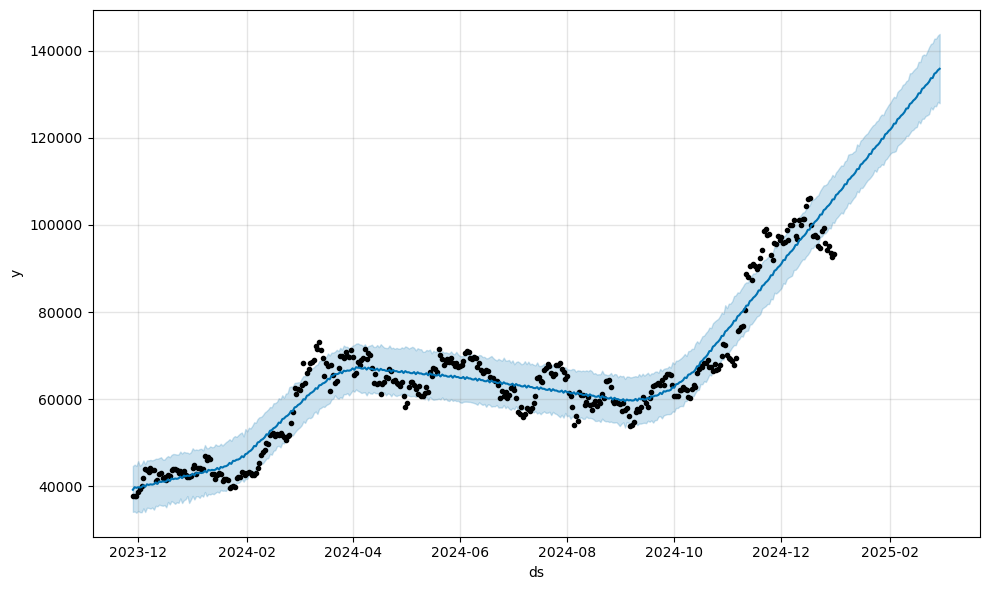

In [9]:

prop_df = df[['timeOpen','close']].rename(columns={'timeOpen':'ds','close':'y'})

# ❗ REMOVE TIMEZONE
prop_df['ds'] = pd.to_datetime(prop_df['ds']).dt.tz_localize(None)

model = Prophet()
model.fit(prop_df)

future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

model.plot(forecast)
plt.show()